### 集成学习和随机森林

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

如果你合并了一组分类器的预测（像分类或者回归），你也会得到一个比单一分类器更好的预测结果。这一组分类器就叫做集成；因此，这个技术就叫做集成学习，一个集成学习算法就叫做集成方法。 

你可以训练一组决策树分类器，每一个都在一个随机的训练集上。为了去做预测，你必须得到所有单一树的预测值，然后通过投票（例如第六章的练习）来预测类别。例如一种决策树的集成就叫做随机森林，它除了简单之外也是现今存在的最强大的机器学习算法之一

### Voting Classifiers 投票分类
![image.png](./images/07_voting_classifiers.png)    
一个非常简单去创建一个更好的分类器的方法就是去整合每一个分类器的预测然后经过投票去预测分类。这种分类器就叫做**硬投票分类器（hard voting classifier）**。
![image.png](./images/07_hard_voting_classifier.png)   



大数定律（law of large numbers）  
假设你有一个有偏差的硬币，他有 51% 的几率为正面，49% 的几率为背面。因为大数定律：当你一直用硬币实验时，正面的比例会越来越接近 51%。
![image](./images/07_law_of_large_numbers.png)

如果每一个分类器都使用相同的数据，相同的算法，可能会犯同样的错误，很难达到很高的准确率。   
如果使每一个分类器都独立自主的分类，那么集成模型会工作的很好。去得到多样的分类器的方法之一就是用完全不同的算法，这会使它们会做出不同种类的错误，这会提高集成的正确率。

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [5]:
# accuracy
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### 软投票 soft voting
如果所有的分类器都能够预测类别的概率（例如他们有一个predict_proba()方法），那么你就可以让 sklearn 以最高的类概率来预测这个类，平均在所有的分类器上。这种方式叫做软投票。    
软投票是使用各个算法输出的类概率来进行类的选择，输入权重的话，会得到每个类的类概率的加权平均值，值大的类会被选择。    
你可以通过把voting="hard"设置为voting="soft"来保证分类器可以预测类别概率

### Bagging 和 Pasting  
对每一个分类器都使用相同的训练算法，但是在不同的训练集上去训练它们。   
有放回采样被称为装袋（Bagging，是 bootstrap aggregating 的缩写）。无放回采样称为粘贴（pasting）。   
Bagging 和 Pasting 都允许在多个分类器上对训练集进行多次采样，但只有 Bagging 允许对同一种分类器上对训练集进行进行多次采样。  
![image](./images/07_bagging_pasting.png)    
当所有的分类器被训练后，集成可以通过对所有分类器结果的简单聚合来对新的实例进行预测。聚合函数通常是分类的统计模式，或者对回归的平均。每一个单独的分类器在如果在原始训练集上都是高偏差，但是聚合降低了偏差和方差。通常情况下，集成的结果是有一个相似的偏差，但是对比与在原始训练集上的单一分类器来讲有更小的方差。   
不同的分类器可以并行，所以扩展性很好

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# bootstrap: True -> Bagging False -> Pasting;  n_jobs: cpu number
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


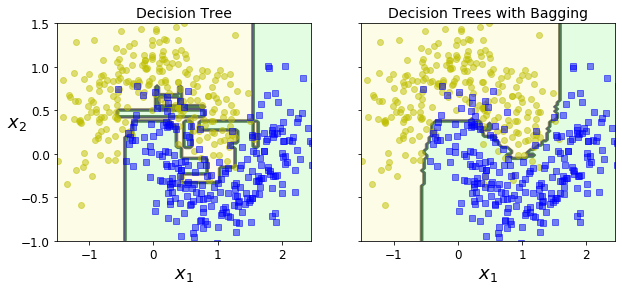

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

#### 上图：单一一个决策树和500个决策树的集成学习的决策边界对比

### Out-of-Bag 评价
对于 Bagging 来说，一些实例可能被一些分类器重复采样，但其他的有可能不会被采样。BaggingClassifier默认采样。BaggingClassifier默认是有放回的采样m个实例 （bootstrap=True），其中m是训练集的大小，这意味着平均下来只有63%的训练实例被每个分类器采样，剩下的37%个没有被采样的训练实例就叫做 Out-of-Bag 实例。注意对于每一个的分类器它们的 37% 不是相同的。
![image.png](images/07_out_of_bag.png)

由于预测器不知道oob 实例，所以可以把它们当做测试集。设置oob_score=True

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500, 
    bootstrap=True, 
    n_jobs=-1, 
    oob_score=True, 
    random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### Random Patches and Random Subspaces  
The BaggingClassifier class supports sampling the features as well. Sampling is controlled by two hyperparameters: max_features and bootstrap_features. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.    
   
Sampling both training instances and features is called the Random Patches method.7 Keeping all training instances (by setting bootstrap=False and max_samples=1.0) but sampling features (by setting bootstrap_features to True and/or max_features to a value smaller than 1.0) is called the Random Subspaces method.8

### 随机森林 Random Forests 
随机森林是决策树的一种集成，通常是通过 bagging 方法（有时是 pasting 方法）进行训练，通常用max_samples设置为训练集的大小。

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

### 极端随机树
当你在随机森林上生长树时，在每个结点分裂时只考虑随机特征集上的特征（正如之前讨论过的一样）。相比于找到更好的特征我们可以通过使用对特征使用随机阈值使树更加随机（像规则决策树一样）。   
  
这种极端随机的树被简称为 Extremely Randomized Trees（极端随机树），或者更简单的称为 Extra-Tree。再一次用高偏差换低方差。它还使得 Extra-Tree 比规则的随机森林更快地训练，因为在每个节点上找到每个特征的最佳阈值是生长树最耗时的任务之一。   

ExtraTreesClassifier

### 特征重要度 Feature Importance
随机森林的另一个特征是可以很容易的测量每个特征的相对的重要度。Scikit-Learn 查看多少节点使用该特征，来测量其重要度。

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


### 提升 Boosting
提升（Boosting，最初称为假设增强）指的是可以将几个弱学习者组合成强学习者的集成方法。对于大多数的提升方法的思想就是按顺序去训练分类器，每一个都要尝试修正前面的分类。现如今已经有很多的提升方法了，但最著名的就是 Adaboost（适应性提升，是 Adaptive Boosting 的简称） 和 Gradient Boosting（梯度提升）。

### AdaBoost  
使一个新的分类器去修正之前分类结果的方法就是对之前分类结果不对的训练实例多加关注。这导致新的预测因子越来越多地聚焦于这种情况。这是 Adaboost 使用的技术。   
  
举个例子，去构建一个 Adaboost 分类器，第一个基分类器（例如一个决策树）被训练然后在训练集上做预测，在误分类训练实例上的权重就增加了。第二个分类机使用更新过的权重然后再一次训练，权重更新。
![image](images/07_adaboost.png)

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

**Weighted error rate of the $j^\text{th}$ predictor**

$
r_j = \dfrac{\displaystyle \sum\limits_{\textstyle {i=1 \atop \hat{y}_j^{(i)} \ne y^{(i)}}}^{m}{w^{(i)}}}{\displaystyle \sum\limits_{i=1}^{m}{w^{(i)}}} \quad
\text{where }\hat{y}_j^{(i)}\text{ is the }j^{\text{th}}\text{ predictor's prediction for the }i^{\text{th}}\text{ instance.}
$  
  
**Predictor weight**

$
\begin{split}
\alpha_j = \eta \log{\dfrac{1 - r_j}{r_j}}
\end{split}
$   
  
**Weight update rule**

$
\begin{split}
& \text{ for } i = 1, 2, \dots, m \\
& w^{(i)} \leftarrow
\begin{cases}
w^{(i)} & \text{if }\hat{y_j}^{(i)} = y^{(i)}\\
w^{(i)} \exp(\alpha_j) & \text{if }\hat{y_j}^{(i)} \ne y^{(i)}
\end{cases}
\end{split}
$

Adaboost 通过分类器权重 $α_{j}$ 简单的计算了所有的分类器和权重。预测类别会是权重投票中主要的类别。  
  
**AdaBoost predictions**

$
\hat{y}(\mathbf{x}) = \underset{k}{\operatorname{argmax}}{\sum\limits_{\scriptstyle j=1 \atop \scriptstyle \hat{y}_j(\mathbf{x}) = k}^{N}{\alpha_j}} \quad N\text{ 是预测器的个数.}
$

sklearn 通常使用 Adaboost 的多分类版本 SAMME（Stagewise Additive Modeling using a Multiclass Exponential loss function 分段加建模使用多类指数损失函数）。  
  
如果分类器可以预测类别概率（例如如果它们有predict_proba()），如果 sklearn 可以使用 SAMME 叫做SAMME.R的变量（R 代表“REAL”），这种依赖于类别概率的通常比依赖于分类器的更好。

### 梯度提升 Gradient Boosting
使用新的分类器去拟合前面分类器预测的残差。

In [25]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [27]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [28]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [29]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [30]:
y_pred

array([0.75026781])

In [32]:
# 这个代码等同于上面的代码
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

![image](images/07_gradient_boosting_regressor.png)

超参数learning_rate 确立了每个树的贡献。如果你把它设置为一个很小的树，例如 0.1，在集成中就需要更多的树去拟合训练集，但预测通常会更好。这个正则化技术叫做 shrinkage。  
  
为了找到树的最优数量，你可以使用早停技术（early stopping）。最简单使用这个技术的方法就是使用staged_predict()：它在训练的每个阶段（用一棵树，两棵树等）返回一个迭代器。

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=56, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
print(bst_n_estimators)

56


你也可以早早的停止训练来实现早停（与先在一大堆树中训练，然后再回头去找最优数目相反）。你可以通过设置warm_start=True来实现 ，这使得当fit()方法被调用时 sklearn 保留现有树，并允许增量训练。

In [35]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [36]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

61
Minimum validation MSE: 0.002712853325235463


### XGBoost (Extreme Gradient Boosting)
在流行的Python库XGBoost中提供了梯度增强的优化实现，XGBoost代表极端梯度增强。

In [37]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[00:08:14] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
# XGBoost 提供了很多特性，例如提前停止
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[00:09:16] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	va

### Stacking 
这个算法基于一个简单的想法：不使用琐碎的函数（如硬投票）来聚合集合中所有分类器的预测，我们为什么不训练一个模型来执行这个聚合？   
  
底部三个分类器每一个都有不同的值（3.1，2.7 和 2.9），然后最后一个分类器（叫做 blender 或者 meta learner ）把这三个分类器的结果当做输入然后做出最终决策（3.0）。  
![image](images/07_stacking_01.png)

为了训练这个 blender ，一个通用的方法是采用保持集。首先，训练集被分为两个子集，第一个子集被用作训练第一层。
![image](images/07_stacking_02.png)

接下来，第一层的分类器被用来预测第二个子集（保持集）（详见 7-14）。这确保了预测结果很“干净”，因为这些分类器在训练的时候没有使用过这些实例。现在对在保持集中的每一个实例都有三个预测值。我们现在可以使用这些预测结果作为输入特征来创建一个新的训练集（这使得这个训练集是三维的），并且保持目标数值不变。随后 blender 在这个新的训练集上训练，因此，它学会了预测第一层预测的目标值。
![image](images/07_stacking_03.png)

我们可以用这种方法训练不同的 blender （例如一个线性回归，另一个是随机森林等等）：我们得到了一层 blender 。诀窍是将训练集分成三个子集：第一个子集用来训练第一层，第二个子集用来创建训练第二层的训练集（使用第一层分类器的预测值），第三个子集被用来创建训练第三层的训练集（使用第二层分类器的预测值）。以上步骤做完了，我们可以通过逐个遍历每个层来预测一个新的实例。
![image](images/07_stacking_04.png)